# volVal trial structure generation

In [1]:
#write simulator for various trial structures

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random as rd
from matplotlib.animation import FuncAnimation
from IPython.display import HTML 
import csv
import seaborn as sns
import sys
import time
from jupyterthemes import jtplot
# jtplot.style(theme='grade3')
# sns.set()
%matplotlib inline

In [3]:
def genChangePoint(constantChangePoint, lambdaV, nTrials):
    
    #sample changePoint
    changePoint_vec = np.zeros((nTrials))
    changePoints = []

    if constantChangePoint == 0:
        i = 1
        while np.sum(changePoints) < nTrials-1:
            changePoints += list(np.random.poisson(lambdaV,i))   

        #if the sum(epochs) > nTrials, remove the last changePoint 
        #if we want to impose fewer constraints to prioritize integrity of 
        #random selection, we can relax the absolute # of trials 
        if np.sum(changePoints) >= nTrials:
            changePoints = changePoints[0:-1]       

        #convert to trial number indices 
        changeIdx = list(np.cumsum(changePoints))
        #mark change point 
        changePoint_vec[changeIdx] = 1 

    elif constantChangePoint == 1:
        changePoints = np.int(np.random.poisson(lambdaV,1))
        changePoint_vec[changePoints::changePoints] = 1 
        changeIdx = list(np.cumsum(np.repeat(changePoints, np.sum(changePoint_vec))))

    #     print(changeIdx)
    #     print(np.sum(changePoint_vec)*changePoints, changePoints)
    return changePoint_vec, changeIdx

In [4]:
def genStop(propStopTrials, lambdaStop, nTrials):

    #stop trials 
    nStopTrials = np.int(propStopTrials * nTrials)
    stopPoints = np.random.poisson(lambdaStop,nStopTrials) #length
    stopIdx = np.cumsum(stopPoints) #indices

    while stopIdx[-1] >= nTrials: 
        stopPoints = np.random.poisson(lambdaStop,nStopTrials)
        stopIdx = np.cumsum(stopPoints)

    #assign delays to the stop indices 
    nSamplesPerDelay = np.int(nStopTrials/len(ssd))
    ssd_vec = np.zeros((nTrials))
    ssd_vec[:] = np.nan

    np.random.shuffle(stopIdx)

    #need to reshape, otherwise broadcasting problems
    ssd_repeatedVal = np.reshape(np.repeat(ssd, nSamplesPerDelay),nStopTrials) 
    ssd_vec[stopIdx] = ssd_repeatedVal
    
    
    return ssd_vec

In [5]:
def genMuSigma(muMin, sigmaMin, sigmaMax, changePoint_vec, changeIdx, nTrials):


    #means and sigma
    nEpochs = np.int(np.sum(changePoint_vec) + 2)
    muMax = 1-sigmaMax
    mu_p = np.random.uniform(muMin, muMax, np.int(nEpochs/2))
    mu_n = -1*mu_p
    muRewardDelta = np.hstack((mu_p, mu_n))
    np.random.shuffle(muRewardDelta)

    #more control over separation between mean values of each epoch
    # muDiff = .05 #greater muDiff = less conflict BETWEEN epochs 
    # test=np.arange(muMin, muMax, muDiff)
    # muControl_shuffle = np.random.uniform(min(test), max(test), len(test))
    # print(test)
    
    #choose smaller sigma (based on mu) to avoid violating boundary of 1 or 0 

    sigma = np.random.uniform(sigmaMin, sigmaMax, 1)
    sigma_vec = np.repeat(sigma, nTrials)

    # print(muRewardDelta_vec.size)


    #sample from a normal distribution to generate reward delta for each trial 
    rewardDelta = np.zeros((nTrials))

    #this adds 0 and the end idx to change idx
    chgidx = [0]+changeIdx+[nTrials-1]

    #constructs unique interval for each mu 
    intervals = [(chgidx[i],chgidx[i+1]) for i in range(len(chgidx)-1)]

    muRewardDelta_vec = np.zeros_like(rewardDelta)
    #each iterator is linked to respective range 
    #zip iterates over two lists simultaneously  
    for interval,mu in zip(intervals,muRewardDelta):
        nElements = interval[1]-interval[0]
        rewardDelta[interval[0]:interval[1]]= np.reshape(np.random.normal(mu,sigma,nElements), (nElements))
        muRewardDelta_vec[interval[0]:interval[1]]= np.reshape(np.repeat(mu,nElements), (nElements))

    #the last element needs to be assigned because of the interval const. above 
    #(range is not inclusive)
    rewardDelta[-1] = np.random.normal(muRewardDelta[-1], sigma, 1)
    muRewardDelta_vec[-1] = muRewardDelta[-1]

    return rewardDelta, muRewardDelta_vec, sigma_vec

In [6]:
def genBaseTargetReward(rewardDelta, nTrials):

    #reverse engineer the actual values for targets

    #assume baseline value of .5 for each
    rewardDelta_div = 0.5*rewardDelta 
    adjustedTargets = 0.5*np.ones((nTrials,2))

    #always add half and subtract half of target value
    adjustedTargets[:,0] +=  rewardDelta_div[:]
    adjustedTargets[:,1] -=  rewardDelta_div[:]

    t1_baseReward = adjustedTargets[:,0]
    t2_baseReward = adjustedTargets[:,1]


    # print(rewardDelta)
    return t1_baseReward, t2_baseReward

In [7]:
def genStaticPlots(nTrials, ssd_vec, t1_baseReward, t2_baseReward, muRewardDelta_vec, 
               rewardDelta):

    x = np.arange(0,nTrials)
    stop_idx = np.isfinite(ssd_vec)


    plt.figure(figsize=(20, 10))
    plt.title("raw target reward structure",fontsize = 40)
    plt.xlabel("trial", fontsize = 30)
    plt.ylabel("reward probability", fontsize = 30)
    plt.scatter(x, t1_baseReward, facecolors='b',edgecolors='b', s = 50)
    plt.scatter(x, t2_baseReward, facecolors='r',edgecolors='r',s = 50)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.legend(["t1", "t2"], fontsize = 20, frameon=True, facecolor = [.7, .7, .7], loc = 'best')
    plt.savefig('t1t2_rewardTimecourse.pdf')


    plt.figure(figsize=(20, 10))
    plt.title("reward structure", fontsize = 40)
    plt.xlabel("trial", fontsize = 30)
    plt.ylabel("$\Delta$ reward probability [t1 - t2]", fontsize = 30)
    plt.plot(muRewardDelta_vec, '0.85')
    plt.scatter(x, rewardDelta,  s = 50,edgecolor='none', facecolor = 'purple')
    plt.plot(x[stop_idx], rewardDelta[stop_idx], 'rs',
            alpha = .5)
    ax = plt.gca()
    ax.grid(True)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.savefig('diff_rewardTimecourse.pdf')
    plt.show()

    return None

In [8]:
def animatePlots(nTrials, ssd_vec, t1_baseReward, t2_baseReward, muRewardDelta_vec, 
               rewardDelta):

    x = np.arange(0,nTrials)

    # target 1 and 2 reward 
    t1t2_reward_fig = plt.figure(figsize=(20, 10))
    plt.plot()
    plt.xlim(0, nTrials)
    plt.ylim(0, 1)
    graph, = plt.plot([], [], 'bo')
    graph2, = plt.plot([], [], 'ro')

    plt.title("raw target reward structure",fontsize = 40)
    plt.xlabel("trial", fontsize = 30)
    plt.ylabel("reward probability", fontsize = 30)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.legend(["t1", "t2"], fontsize = 20, frameon=True, facecolor = [.7, .7, .7], loc = 'best')


    def animate(i):
        graph.set_data(x[:i+1], t1_baseReward[:i+1])
        graph2.set_data(x[:i+1], t2_baseReward[:i+1])

        return graph

    anim = FuncAnimation(t1t2_reward_fig, animate, frames=nTrials, interval=5)
    plt.show()
    HTML(anim.to_html5_video())

    anim.save('t1t2_rewardTimecourse.mp4',extra_args=['-vcodec', 'libx264'])


    #reward structure diff 
    stop_idx = np.isfinite(ssd_vec)
    stop_x = x[stop_idx]
    stop_rewardDelta = rewardDelta[stop_idx]

    rewardDelta_fig = plt.figure(figsize=(20, 10))
    plt.plot()
    plt.xlim(0, nTrials)
    plt.ylim(-1, 1)

    graph, = plt.plot([], [], '0.85')
    graph2, = plt.plot([], [], 'o', color = 'purple')
    graph3, = plt.plot([], [], 'rs', alpha = 0.5)


    plt.title("reward structure", fontsize = 40)
    plt.xlabel("trial", fontsize = 30)
    plt.ylabel("$\Delta$ reward probability [t1 - t2]", fontsize = 30)


    def animate_data(i):
        graph.set_data(x[:i+1], muRewardDelta_vec[:i+1])
        graph2.set_data(x[:i+1], rewardDelta[:i+1])
        graph3.set_data(stop_x[:i+1], stop_rewardDelta[:i+1])
        return graph

    anim = FuncAnimation(rewardDelta_fig, animate_data, frames=nTrials, interval=5)
    plt.show()
    HTML(anim.to_html5_video())

    anim.save('diff_rewardTimecourse.mp4', extra_args=['-vcodec', 'libx264'])

    return None


In [9]:
#print to file specified by user
def printParameters(t1_baseReward, t2_baseReward, ssd_vec, changePoint_vec, rewardDelta, 
                muRewardDelta_vec, sigma_vec):
    filename = input('Enter a filename: ')
    taskParameters = np.array((t1_baseReward, t2_baseReward, ssd_vec, changePoint_vec, rewardDelta, 
                muRewardDelta_vec, sigma_vec))
    taskParameters = np.matrix.transpose(taskParameters)
    header = ("t1_baseReward, t2_baseReward, ssd_vec, changePoint_vec, rewardDelta, muRewardDelta, sigma_vec")
    np.savetxt(filename + '.csv',taskParameters, header = header, delimiter=',', comments = '', fmt='%f') 
    return None

In [10]:
def generateTrialStructure(nTrials, lambdaV, lambdaStop, ssd, sigmaMin, sigmaMax,
                           propStopTrials, constantChangePoint, animate):
         
    if nTrials <= 0 or np.mod(nTrials,2) > 0:
        raise ValueError("nTrials must be a positive, even integer > 0")
        return None 
    if sigmaMin < 0: 
        raise ValueError("sigmaMin must be a positive integer")
        return None 
    if propStopTrials > 1 or propStopTrials < 0: 
        raise ValueError("propStopTrials must be a positive value between 0 and 1")
        return None
    if (constantChangePoint != 1 and constantChangePoint != 0):
        raise ValueError("constantChangePoint must be a boolean [0 or 1]")
        return None 

    changePoint_vec, changeIdx = genChangePoint(constantChangePoint, lambdaV, nTrials)
    ssd_vec = genStop(propStopTrials, lambdaStop, nTrials)
    rewardDelta, muRewardDelta_vec, sigma_vec = genMuSigma(muMin, sigmaMin, 
                                 sigmaMax, changePoint_vec, changeIdx, nTrials)
    t1_baseReward, t2_baseReward = genBaseTargetReward(rewardDelta, nTrials)
  
    #small chance that reward diff > 1 or <0 (potential if sigma is high & 
    #sample is drawn from > 1 std). if so, re-sample.
    while np.any(t1_baseReward > 1) or np.any(t1_baseReward < 0) or np.any(t2_baseReward > 1) or np.any(t2_baseReward < 0): 
        rewardDelta, muRewardDelta_vec, sigma_vec = genMuSigma(muMin, sigmaMin, sigmaMax, 
                         changePoint_vec, changeIdx, nTrials)
        t1_baseReward, t2_baseReward = genBaseTargetReward(rewardDelta, nTrials)
    
    #print parameters to user-specified filename    
    printParameters(t1_baseReward, t2_baseReward, ssd_vec, changePoint_vec, rewardDelta, 
                muRewardDelta_vec, sigma_vec)
    genStaticPlots(nTrials, ssd_vec, t1_baseReward, t2_baseReward, muRewardDelta_vec, 
               rewardDelta)
    if animate == 1: 
        animatePlots(nTrials, ssd_vec, t1_baseReward, t2_baseReward, muRewardDelta_vec, 
               rewardDelta)
        
        
    return t1_baseReward, t2_baseReward, ssd_vec, changePoint_vec, rewardDelta, muRewardDelta_vec, sigma_vec

Enter a filename: test


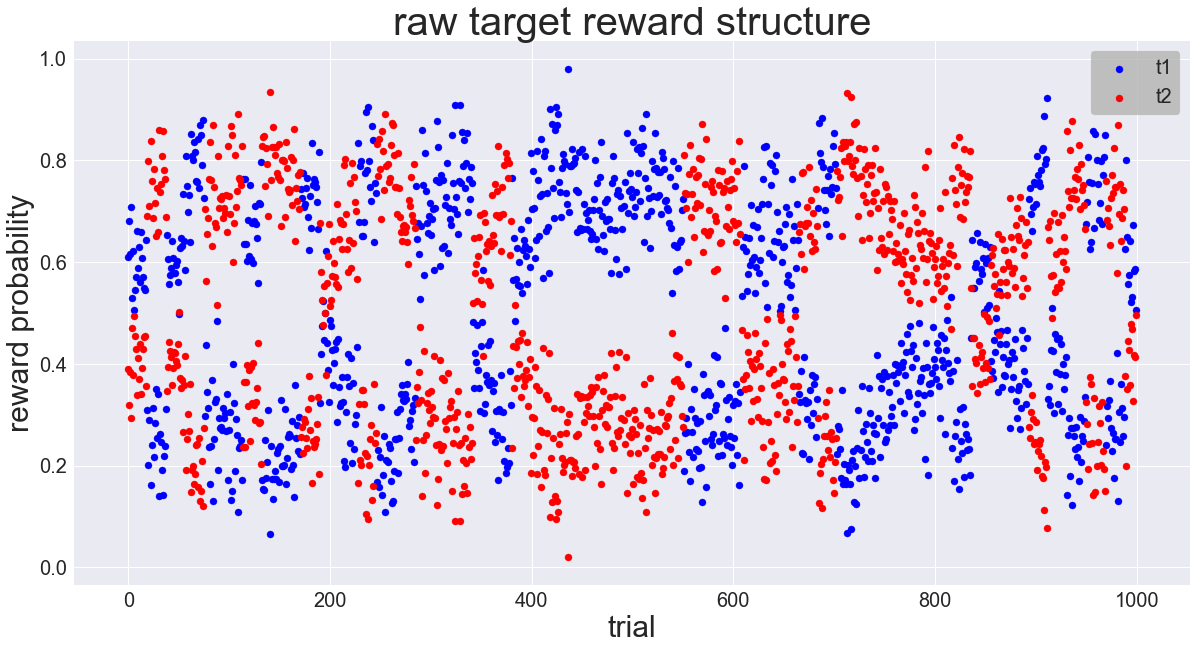

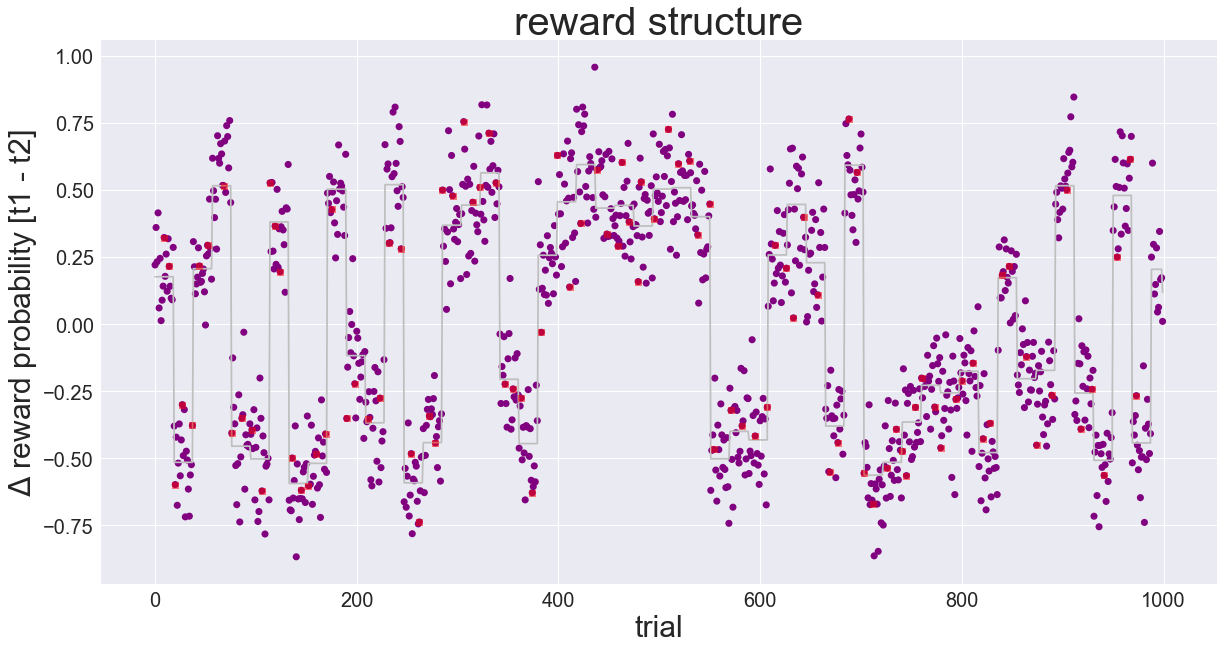

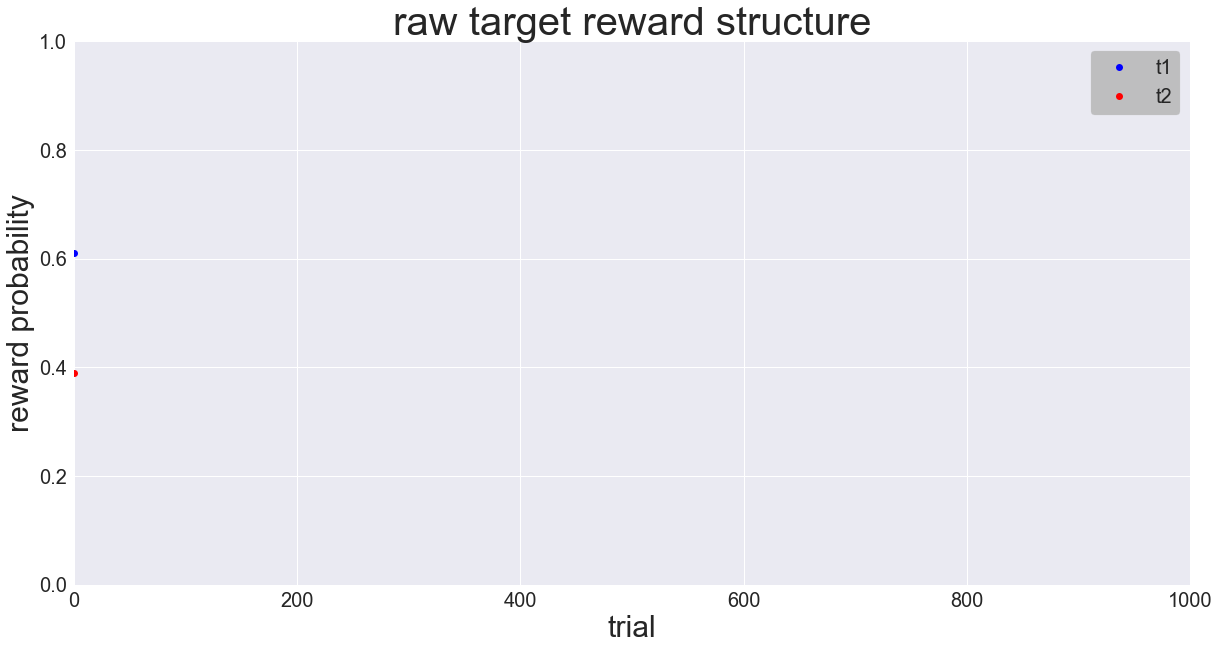

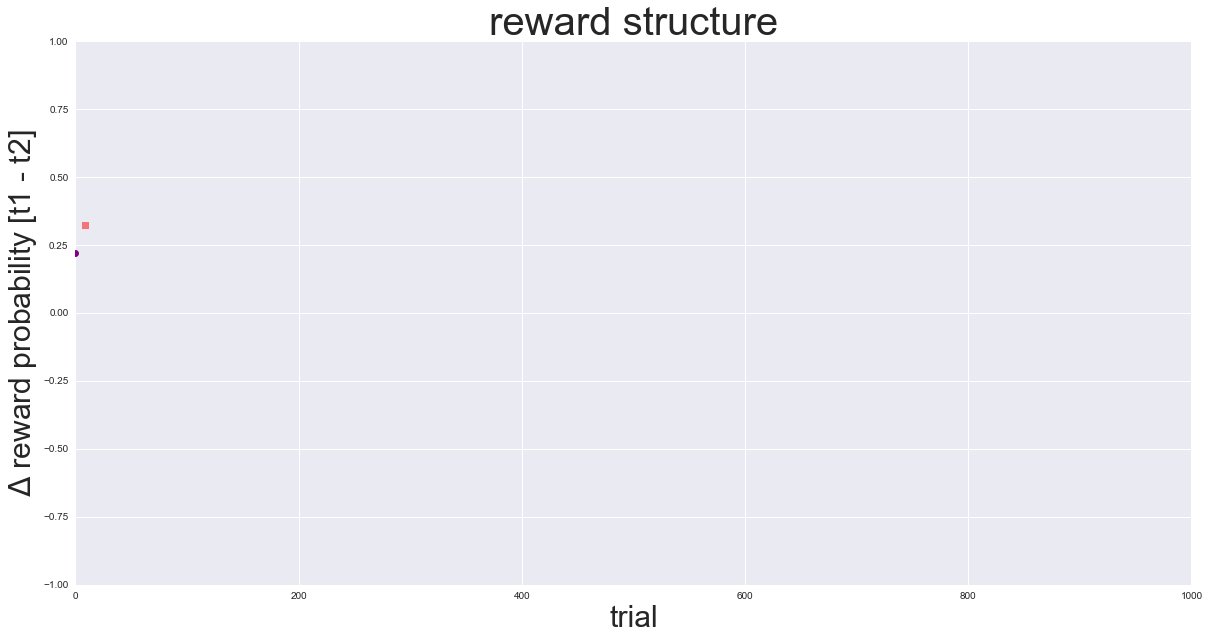

In [11]:
nTrials = 1000
lambdaV = 20
lambdaStop = 10  
ssd = np.array([200, 250, 300, 350, 450])

propStopTrials = .10
constantChangePoint = 1
muMin = .1 #change this to increase conflict within trial
sigmaMax = .4
sigmaMin = 0 
animate = 1


(t1_baseReward, t2_baseReward, ssd_vec, changePoint_vec, 
rewardDelta, muRewardDelta_vec, sigma_vec) = generateTrialStructure(nTrials,
lambdaV, lambdaStop, ssd, sigmaMin, sigmaMax, propStopTrials, 
constantChangePoint, animate) 